##### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import SeqMTGradientBoostingRegressor as SMTGBR
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm, trange

DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

NAMES = [
    "Dummy",
    "Linear",
    "Gradient Boosting",
    "JOPLEn",
    "Dirty LASSO",
    "BoUTS",
]

OUT_PATH = Path(".") / "manual"

##### Function definitions

In [2]:
def train_model(ModelClass, x_train, y_train, x_val, y_val, x_test, y_test, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(len(x_train))):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return pd.DataFrame(output).T

In [3]:
def jp_mask(jp_model):
    core_mask = np.linalg.norm(jp_model.cwb.get()[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(jp_model.cws.get()[:, :-1], axis=2) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask


def dl_mask(dl_model):
    core_mask = np.any(np.abs(dl_model.coef_shared_.T) > 1e-4, axis=0)
    task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask

In [4]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def dl_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)


def score_dl(model, x_train, y_train, x_val, y_val, x_test, y_test, masks=None):
    if masks is not None and len(masks) != 3:
        raise ValueError("You should include train, val, and test masks")

    if masks is None:
        train_mask = np.ones(x_train.shape[:2], dtype=bool)
        val_mask = np.ones(x_val.shape[:2], dtype=bool)
        test_mask = np.ones(x_test.shape[:2], dtype=bool)
    else:
        train_mask, val_mask, test_mask = masks

    y_train_err, y_val_err, y_test_err = [], [], []

    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    for i in range(x_train.shape[0]):
        y_train_err.append(
            mse(y_train[i, train_mask[i]], y_train_pred[i, train_mask[i]])
        )
        y_val_err.append(mse(y_val[i, val_mask[i]], y_val_pred[i, val_mask[i]]))
        y_test_err.append(mse(y_test[i, test_mask[i]], y_test_pred[i, test_mask[i]]))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def dl_plot(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    axs[0].matshow(model.coef_shared_)
    axs[0].set_title("Shared Coefficients")

    axs[1].matshow(model.coef_specific_)
    axs[1].set_title("Specific Coefficients")

    for ax in axs:
        ax.set_ylabel("Features")
        ax.set_xlabel("Tasks")

    plt.tight_layout()

    core_mask, task_mask = dl_mask(model)

    print("Core features:", np.sum(core_mask))
    print(f"Task features: {list(np.sum(task_mask, axis=1))}: {np.sum(task_mask)}")

In [5]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(model, dpi=300):
    # get weights without bias term
    core_weights = model.cwb.get()[:, :-1]
    task_weights = model.cws.get()[:, :-1]

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=dpi)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[0].set_title("Core Weights")
    axs[1].matshow(task_weights, **params)
    axs[1].set_title("Task Weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_xlabel("Tasks, partitions, and cells")
        ax.set_ylabel("Features")

    plt.tight_layout()
    plt.show()

    # print the number of weights that are nonzero
    core_mask, task_mask = jp_mask(model)

    print(f"Number of nonzero core weights: {core_mask.sum()}")
    print(
        f"Number of nonzero task weights: {list(task_mask.sum(axis=1))}: {task_mask.sum()}"
    )


def plot_bouts_weights(bouts: SMTGBR):
    univ_mask = np.logical_or(
        bouts.univ_feat_penalty_mask == 0,
        np.all(
            bouts.task_feat_penalty_mask == 0,
            axis=0,
        ),
    )
    task_or_univ_mask = bouts.task_feat_penalty_mask == 0
    task_mask = np.logical_and(task_or_univ_mask, ~univ_mask)

    n_univ = univ_mask.sum()
    n_task = task_mask.sum(axis=1)

    return n_univ, n_task, sum(n_task)

In [6]:
def score_jp(model: MTJOPLEn, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = []
    y_val_err = []
    y_test_err = []

    for i in range(len(x_train)):
        y_train_err.append(mse(y_train[i], model.predict(x_train[i], i).flatten()))
        y_val_err.append(mse(y_val[i], model.predict(x_val[i], i).flatten()))
        y_test_err.append(mse(y_test[i], model.predict(x_test[i], i).flatten()))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(len(x_train))]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def compare_feats(jp_model, dl_model):
    jp_core_feats, jp_task_feats = jp_mask(jp_model)
    dl_core_feats, dl_task_feats = dl_mask(dl_model)

    results = [
        np.sum(jp_core_feats | jp_task_feats, axis=1),
        np.sum(dl_core_feats | dl_task_feats, axis=1),
    ]

    df = pd.DataFrame(results, columns=[f"task_{i}" for i in range(len(jp_task_feats))])
    df.index = ["JOPLEn", "Dirty LASSO"]

    return df


def train_masked_gb(
    x_train, y_train, x_val, y_val, x_test, y_test, core_mask, task_mask
):
    both_masks = core_mask | task_mask

    errors = []

    for i in trange(len(x_train)):
        model = GradientBoostingRegressor()
        model.fit(x_train[i][:, both_masks[i]], y_train[i])

        errors.append(
            {
                "train": mse(y_train[i], model.predict(x_train[i][:, both_masks[i]])),
                "val": mse(y_val[i], model.predict(x_val[i][:, both_masks[i]])),
                "test": mse(y_test[i], model.predict(x_test[i][:, both_masks[i]])),
            }
        )

    return pd.DataFrame(errors)

In [7]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, _ in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [8]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [9]:
def scatter_test(x_data, y_data, x_name, y_name):
    plt.scatter(x_data["test"], y_data["test"])

    xlim, ylim = plt.xlim(), plt.ylim()

    max_val = max(xlim[1], ylim[1])

    plt.plot([0, 10], [0, 10], "k--")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.gca().set_aspect("equal")

    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()

In [10]:
def save_results(
    dataset,
    jp_res,
    dl_res,
    bouts_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
    bouts_model,
):
    path = OUT_PATH / dataset

    path.mkdir(parents=True, exist_ok=True)

    # prediction performance
    jp_res.to_csv(path / "joplen.csv")
    dl_res.to_csv(path / "dl.csv")
    bouts_res.to_csv(path / "bouts.csv")
    dummy_results.to_csv(path / "dummy.csv")
    linear_results.to_csv(path / "linear.csv")
    gb_results.to_csv(path / "gb.csv")

    # weights
    jp_path = path / "joplen"
    jp_path.mkdir(parents=True, exist_ok=True)
    np.save(jp_path / "core.npy", jp_model.cwb.get())
    np.save(jp_path / "task.npy", jp_model.cws.get())

    dl_path = path / "dirty_lasso"
    dl_path.mkdir(parents=True, exist_ok=True)
    np.save(dl_path / "core.npy", dl_model.coef_shared_)
    np.save(dl_path / "task.npy", dl_model.coef_specific_)

    # penalty mask
    bouts_path = path / "bouts"
    bouts_path.mkdir(parents=True, exist_ok=True)
    np.save(bouts_path / "univ.npy", bouts_model.univ_feat_penalty_mask)
    np.save(bouts_path / "task.npy", bouts_model.task_feat_penalty_mask)


def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

##### SARCOS

In [11]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

# SARCOS is multi-output but JOPLEn assumes multi-task
x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [12]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(Ridge, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    max_depth=3,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:00<00:00, 13.06it/s]

Dummy Results


,train,val,test
task 0,1.0,1.032,0.983
task 1,1.0,1.011,0.978
task 2,1.0,1.019,0.991
task 3,1.0,1.020,0.979
task 4,1.0,1.037,1.010
task 5,1.0,0.994,0.973
task 6,1.0,1.010,0.984


Linear Results


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


GB Results


,train,val,test
task 0,0.059,0.063,0.060
task 1,0.060,0.063,0.062
task 2,0.060,0.063,0.062
task 3,0.024,0.026,0.026
task 4,0.081,0.088,0.086
task 5,0.102,0.109,0.105
task 6,0.037,0.039,0.040


Core features: 5
Task features: [3, 3, 3, 2, 8, 5, 3]: 27


,train,val,test
task 0,0.105,0.103,0.104
task 1,0.125,0.124,0.121
task 2,0.107,0.110,0.102
task 3,0.070,0.071,0.069
task 4,0.194,0.201,0.192
task 5,0.335,0.337,0.327
task 6,0.095,0.096,0.095


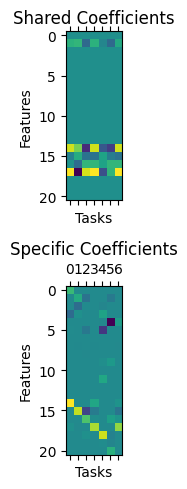

In [13]:
from mutar import DirtyModel

dl_model = DirtyModel(
    alpha=0.1,  # shared penalty
    beta=0.0442,  # task-specific penalty
)
dl_model.fit(x_train, y_train)

dl_plot(dl_model)

dl_res = score_dl(dl_model, x_train, y_train, x_val, y_val, x_test, y_test)
display(dl_res.round(3))

In [14]:
vpart_params = (
    {"n_partitions": 100, "n_cells": 8},
    {
        "max_iters": 2000,
        "lam_core": 0.7,
        "lam_task": 0.3,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 100,
        "mu": 1e-3,
    },
)

jp_model = MTJOPLEn(
    VPartition,
    **vpart_params[0],
    random_state=0,
)
history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
    verbose=True,
)

Partition tasks: 100%|██████████| 7/7 [00:00<00:00, 5178.15it/s]


[20:01:58]: Epoch    100 | TrL: 0.383714, 0.358748, 0.326798, 0.299332, 0.389312, 0.443341, 0.313491 | VaL: 0.383818, 0.355524, 0.328415, 0.303494, 0.395946, 0.442243, 0.314392 | CNorm: 0.467609 | TNorm: 0.912001 | CFNorm: 0.023392 | TFNorm: 0.023392 | WbNz:   17 | WsNz:    0,    0,    0,    0,    1,    3,    1
[20:02:00]: Epoch    200 | TrL: 0.352791, 0.338747, 0.308654, 0.276519, 0.380251, 0.429927, 0.292694 | VaL: 0.352642, 0.335905, 0.310461, 0.280014, 0.386169, 0.429275, 0.293072 | CNorm: 0.428126 | TNorm: 0.841017 | CFNorm: 0.032525 | TFNorm: 0.032525 | WbNz:   12 | WsNz:    0,    1,    0,    0,    1,    6,    0
[20:02:01]: Epoch    300 | TrL: 0.341568, 0.330705, 0.303648, 0.270964, 0.375302, 0.425270, 0.287054 | VaL: 0.341352, 0.328094, 0.305341, 0.274218, 0.380668, 0.425119, 0.287180 | CNorm: 0.376042 | TNorm: 0.810669 | CFNorm: 0.039660 | TFNorm: 0.039660 | WbNz:   10 | WsNz:    1,    1,    0,    0,    1,    4,    0
[20:02:02]: Epoch    400 | TrL: 0.334259, 0.328343, 0.301008,

,train,val,test
task 0,0.102,0.102,0.097
task 1,0.108,0.108,0.109
task 2,0.098,0.100,0.094
task 3,0.075,0.078,0.074
task 4,0.133,0.137,0.134
task 5,0.184,0.187,0.180
task 6,0.087,0.088,0.087


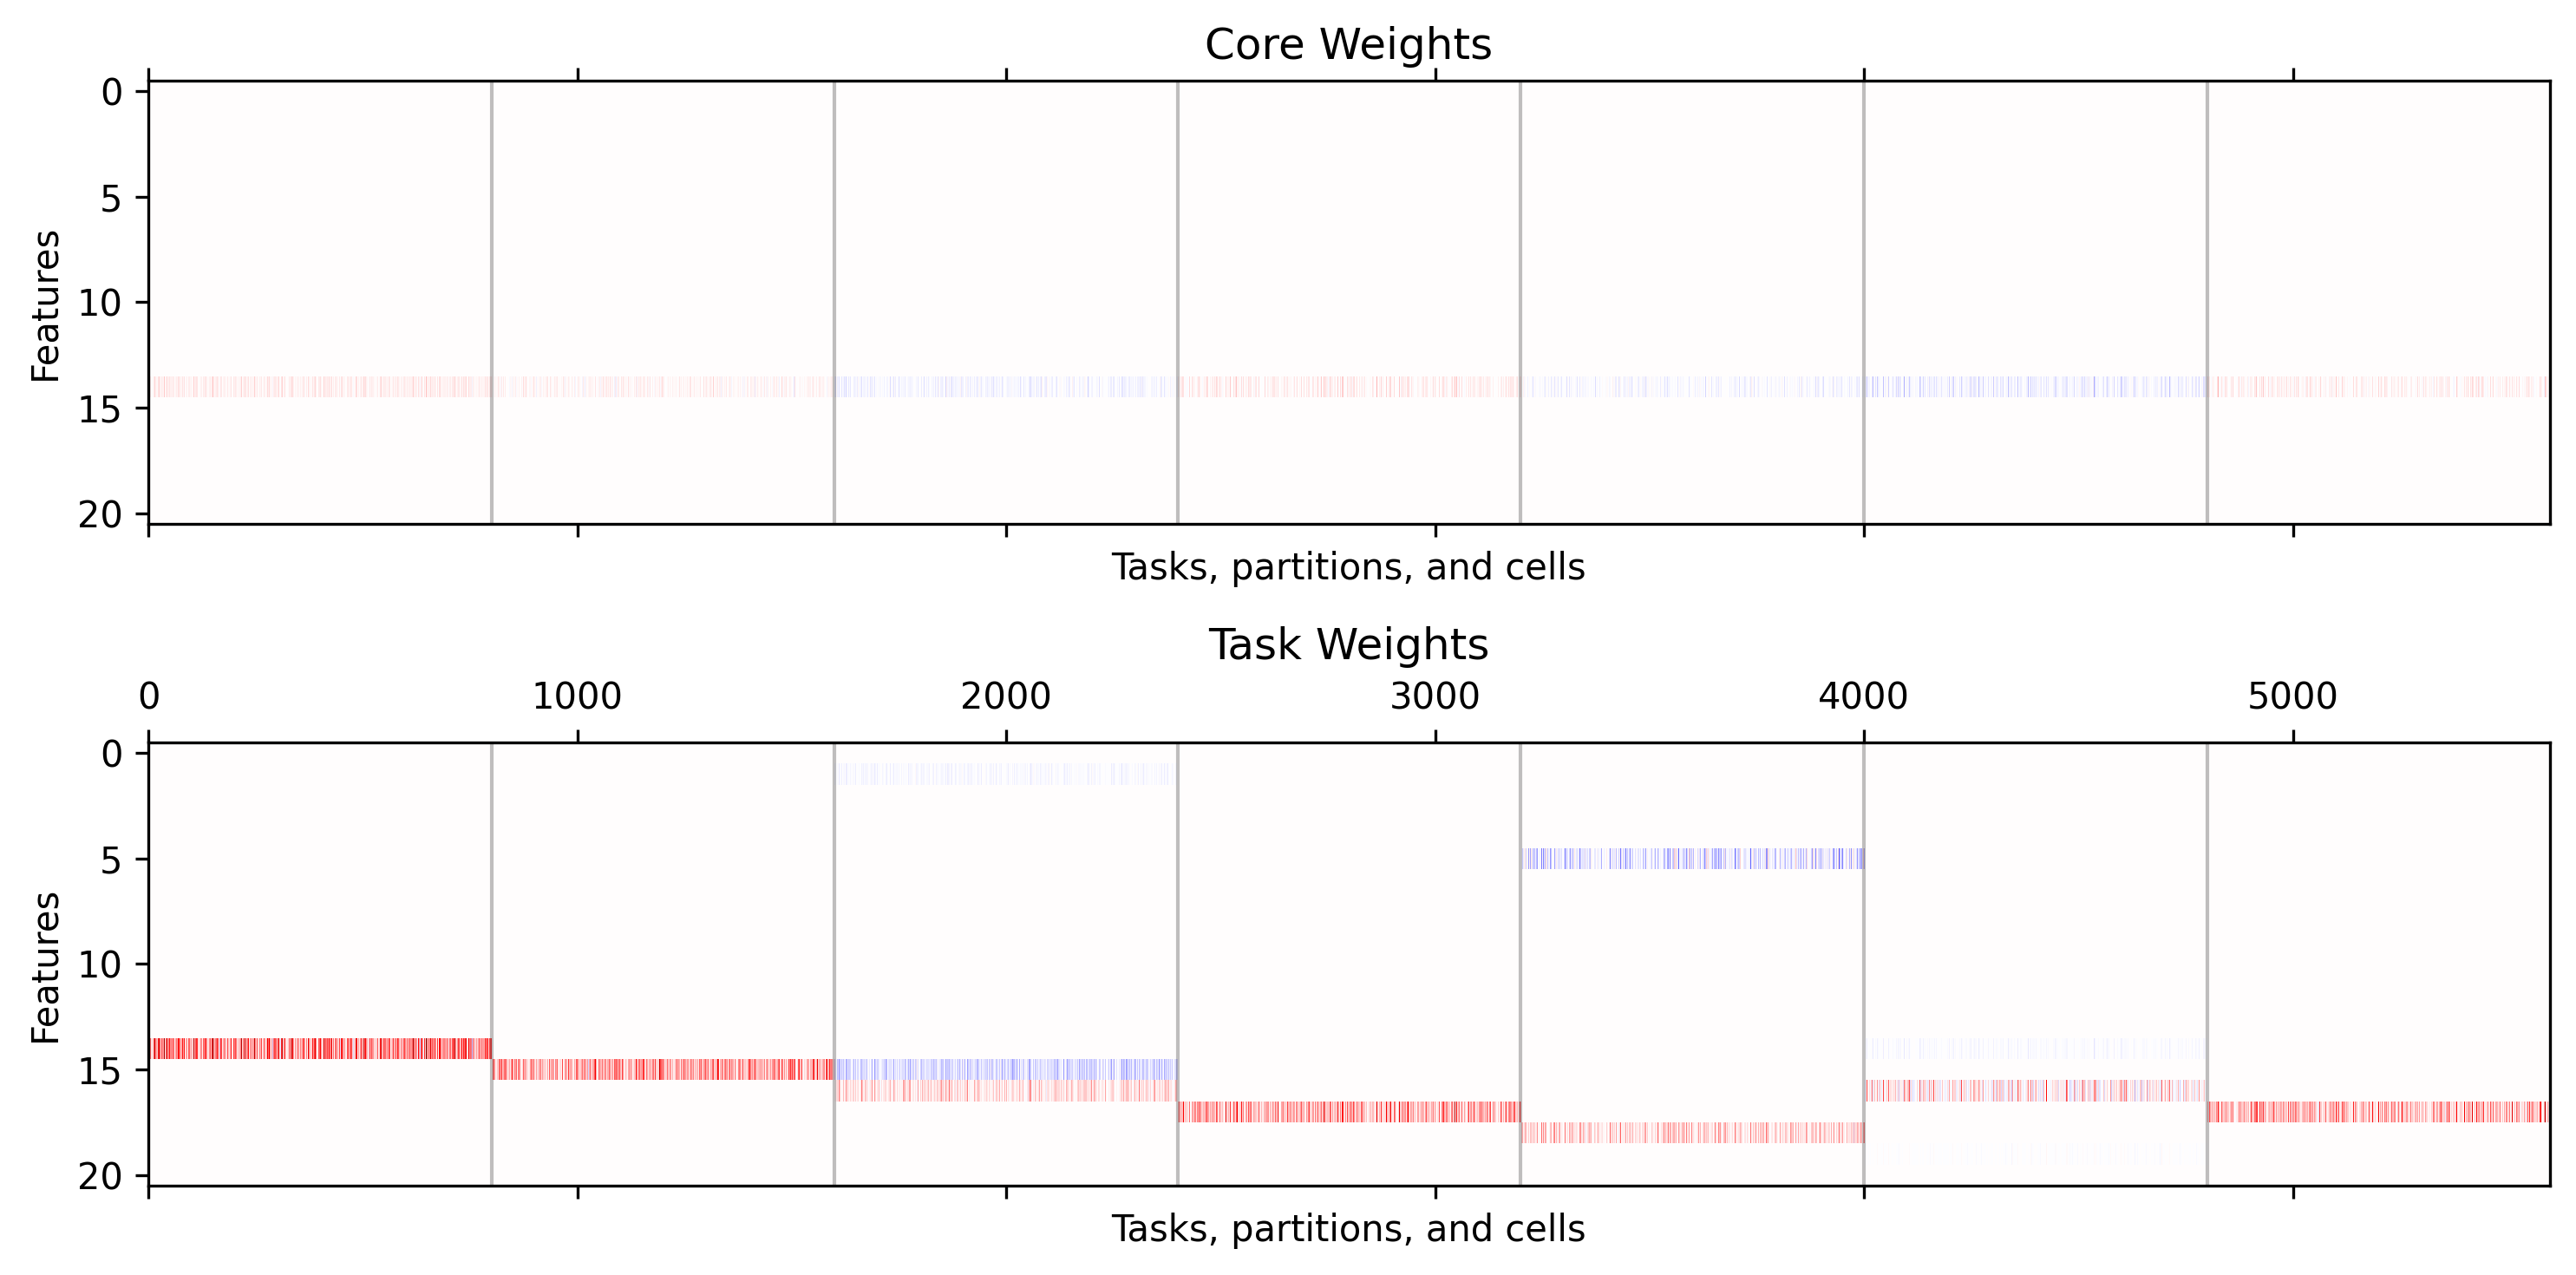

Number of nonzero core weights: 1
Number of nonzero task weights: [0, 1, 3, 1, 2, 2, 1]: 10


In [15]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

In [16]:
sarcos_df = compare_feats(jp_model, dl_model)
sarcos_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6
JOPLEn,1,2,4,2,3,3,2
Dirty LASSO,8,8,8,7,13,10,8


In [17]:
bouts_model = SMTGBR(
    n_mt_estimators=50,
    n_st_estimators=50,
    max_depth=3,
    random_state=0,
    n_tasks=7,
    feature_penalty=0.0,
)

# Some manipulation to get weighting that technically isn't supported by the library
bouts_model.univ_feat_penalty_mask = np.ones(x_train.shape[-1]) * 2000
bouts_model.task_feat_penalty_mask = (
    np.ones((bouts_model.n_tasks, x_train.shape[-1])) * 200
)

bouts_model.fit(x_train.astype(np.float32), y_train.astype(np.float32))

SeqMTGradientBoostingRegressor(n_tasks=7, random_state=0)

In [18]:
bouts_res = score_jp(
    bouts_model,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
)

display(bouts_res.round(3))

plot_bouts_weights(bouts_model)

,train,val,test
task 0,0.115,0.121,0.121
task 1,0.132,0.141,0.137
task 2,0.164,0.170,0.167
task 3,0.079,0.087,0.086
task 4,0.136,0.144,0.146
task 5,0.183,0.188,0.187
task 6,0.086,0.093,0.092


(3, array([4, 3, 3, 2, 5, 3, 4]), 24)

In [19]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *jp_mask(jp_model))

100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


,train,val,test
0,0.471813,0.473425,0.475222
1,0.262406,0.271811,0.269922
2,0.069378,0.074202,0.072550
3,0.076586,0.082108,0.079372
4,0.226316,0.238771,0.236555
5,0.529263,0.551246,0.532372
6,0.099899,0.103346,0.100868


In [20]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *dl_mask(dl_model))

100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


,train,val,test
0,0.067475,0.072030,0.071489
1,0.062532,0.065432,0.063806
2,0.063615,0.068640,0.067442
3,0.033592,0.035855,0.036393
4,0.082660,0.090158,0.087312
5,0.122248,0.129766,0.126178
6,0.049196,0.051784,0.052765


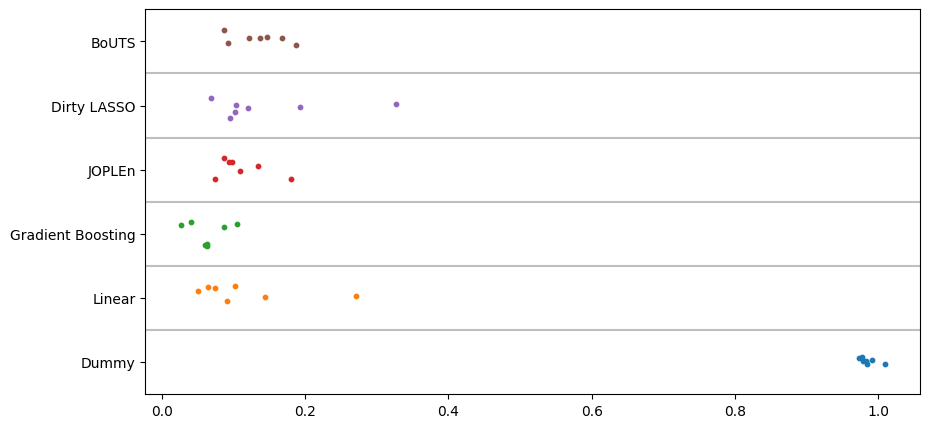

In [21]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res, bouts_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.show()

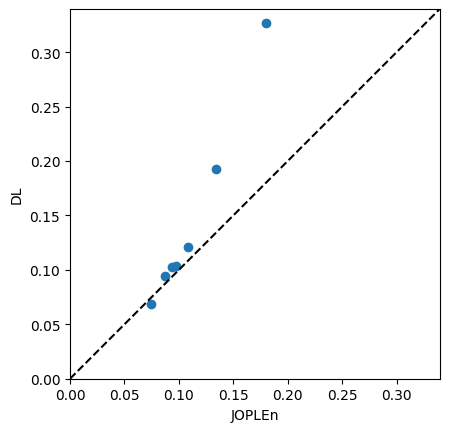

In [22]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")
# DL worse in 2 of the 5, otherwise basically the same

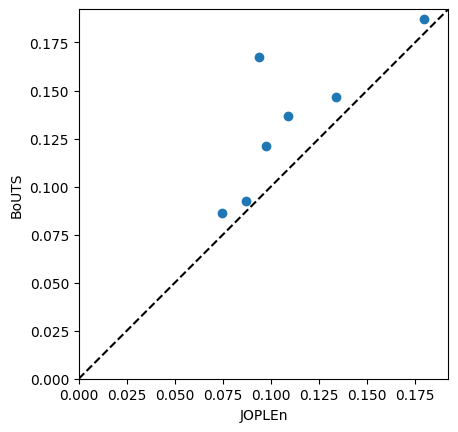

In [23]:
scatter_test(jp_res, bouts_res, "JOPLEn", "BoUTS")

In [24]:
jp_res

,train,val,test
task 0,0.101785,0.102165,0.097362
task 1,0.108496,0.108368,0.108763
task 2,0.097830,0.099590,0.093544
task 3,0.075436,0.077906,0.074437
task 4,0.133125,0.136970,0.133973
task 5,0.183646,0.187108,0.179855
task 6,0.087035,0.087559,0.087009


In [25]:
# save results for plotting
save_results(
    "sarcos",
    jp_res,
    dl_res,
    bouts_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
    bouts_model,
)

---

##### Nanoparticle

In [26]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

    print(dir.name)

mol_boil
mol_henry
mol_logp
mol_melt
np_logp
np_zetap
protein_sol


In [27]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [28]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(Ridge, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    max_depth=3,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:01<00:00,  5.99it/s]

Dummy Results


,train,val,test
task 0,1.0,1.061,1.111
task 1,1.0,1.078,1.147
task 2,1.0,1.046,1.032
task 3,1.0,0.940,1.037
task 4,1.0,0.867,1.011
task 5,1.0,1.055,0.837
task 6,1.0,1.020,1.087


Linear Results


,train,val,test
task 0,0.363,0.832,1.347
task 1,0.112,0.516,0.489
task 2,0.297,0.338,0.339
task 3,0.257,0.472,0.454
task 4,0.046,0.433,4.260
task 5,0.079,0.649,0.729
task 6,0.712,1.034,0.915


GB Results


,train,val,test
task 0,0.207,0.644,0.619
task 1,0.071,0.353,0.261
task 2,0.251,0.315,0.301
task 3,0.180,0.320,0.354
task 4,0.023,0.283,0.125
task 5,0.036,0.401,0.265
task 6,0.502,0.745,0.770


In [29]:
jp_model = MTJOPLEn(
    VPartition,
    n_partitions=100,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    lam_core=2.15,
    lam_task=1.2,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=1e-5,
    rel_lr=[1, 1, 1.1, 1, 1.5, 0.9, 1],
)

Partition tasks: 100%|██████████| 7/7 [00:00<00:00, 930.30it/s]


[20:06:52]: Epoch    100 | TrL: 0.960292, 0.910491, 0.921298, 0.944426, 0.794959, 0.946711, 0.992536 | VaL: 0.985885, 0.968843, 0.943923, 0.918037, 0.816731, 0.981941, 0.999778 | CNorm: 0.071254 | TNorm: 0.108688 | CFNorm: 0.000044 | TFNorm: 0.000044 | WbNz:    2 | WsNz:    0,    0,    0,    0,    7,    0,    0
[20:06:52]: Epoch    200 | TrL: 0.951347, 0.892549, 0.897704, 0.933883, 0.754958, 0.940703, 0.990596 | VaL: 0.975753, 0.954302, 0.920291, 0.908080, 0.796349, 0.974556, 0.997370 | CNorm: 0.079241 | TNorm: 0.130352 | CFNorm: 0.000093 | TFNorm: 0.000093 | WbNz:   33 | WsNz:    0,    0,    0,    0,   12,    0,    0
[20:06:53]: Epoch    300 | TrL: 0.946305, 0.883600, 0.887270, 0.928831, 0.732216, 0.935253, 0.989403 | VaL: 0.969117, 0.946416, 0.909872, 0.903850, 0.784316, 0.968754, 0.996040 | CNorm: 0.082102 | TNorm: 0.140413 | CFNorm: 0.000137 | TFNorm: 0.000137 | WbNz:   36 | WsNz:    0,    0,    1,    0,   18,    0,    0
[20:06:54]: Epoch    400 | TrL: 0.942840, 0.877655, 0.881076,

,train,val,test
task 0,0.778,0.812,0.885
task 1,0.589,0.777,0.731
task 2,0.666,0.708,0.684
task 3,0.688,0.660,0.703
task 4,0.362,0.476,0.424
task 5,0.740,0.900,0.650
task 6,0.920,0.936,0.961


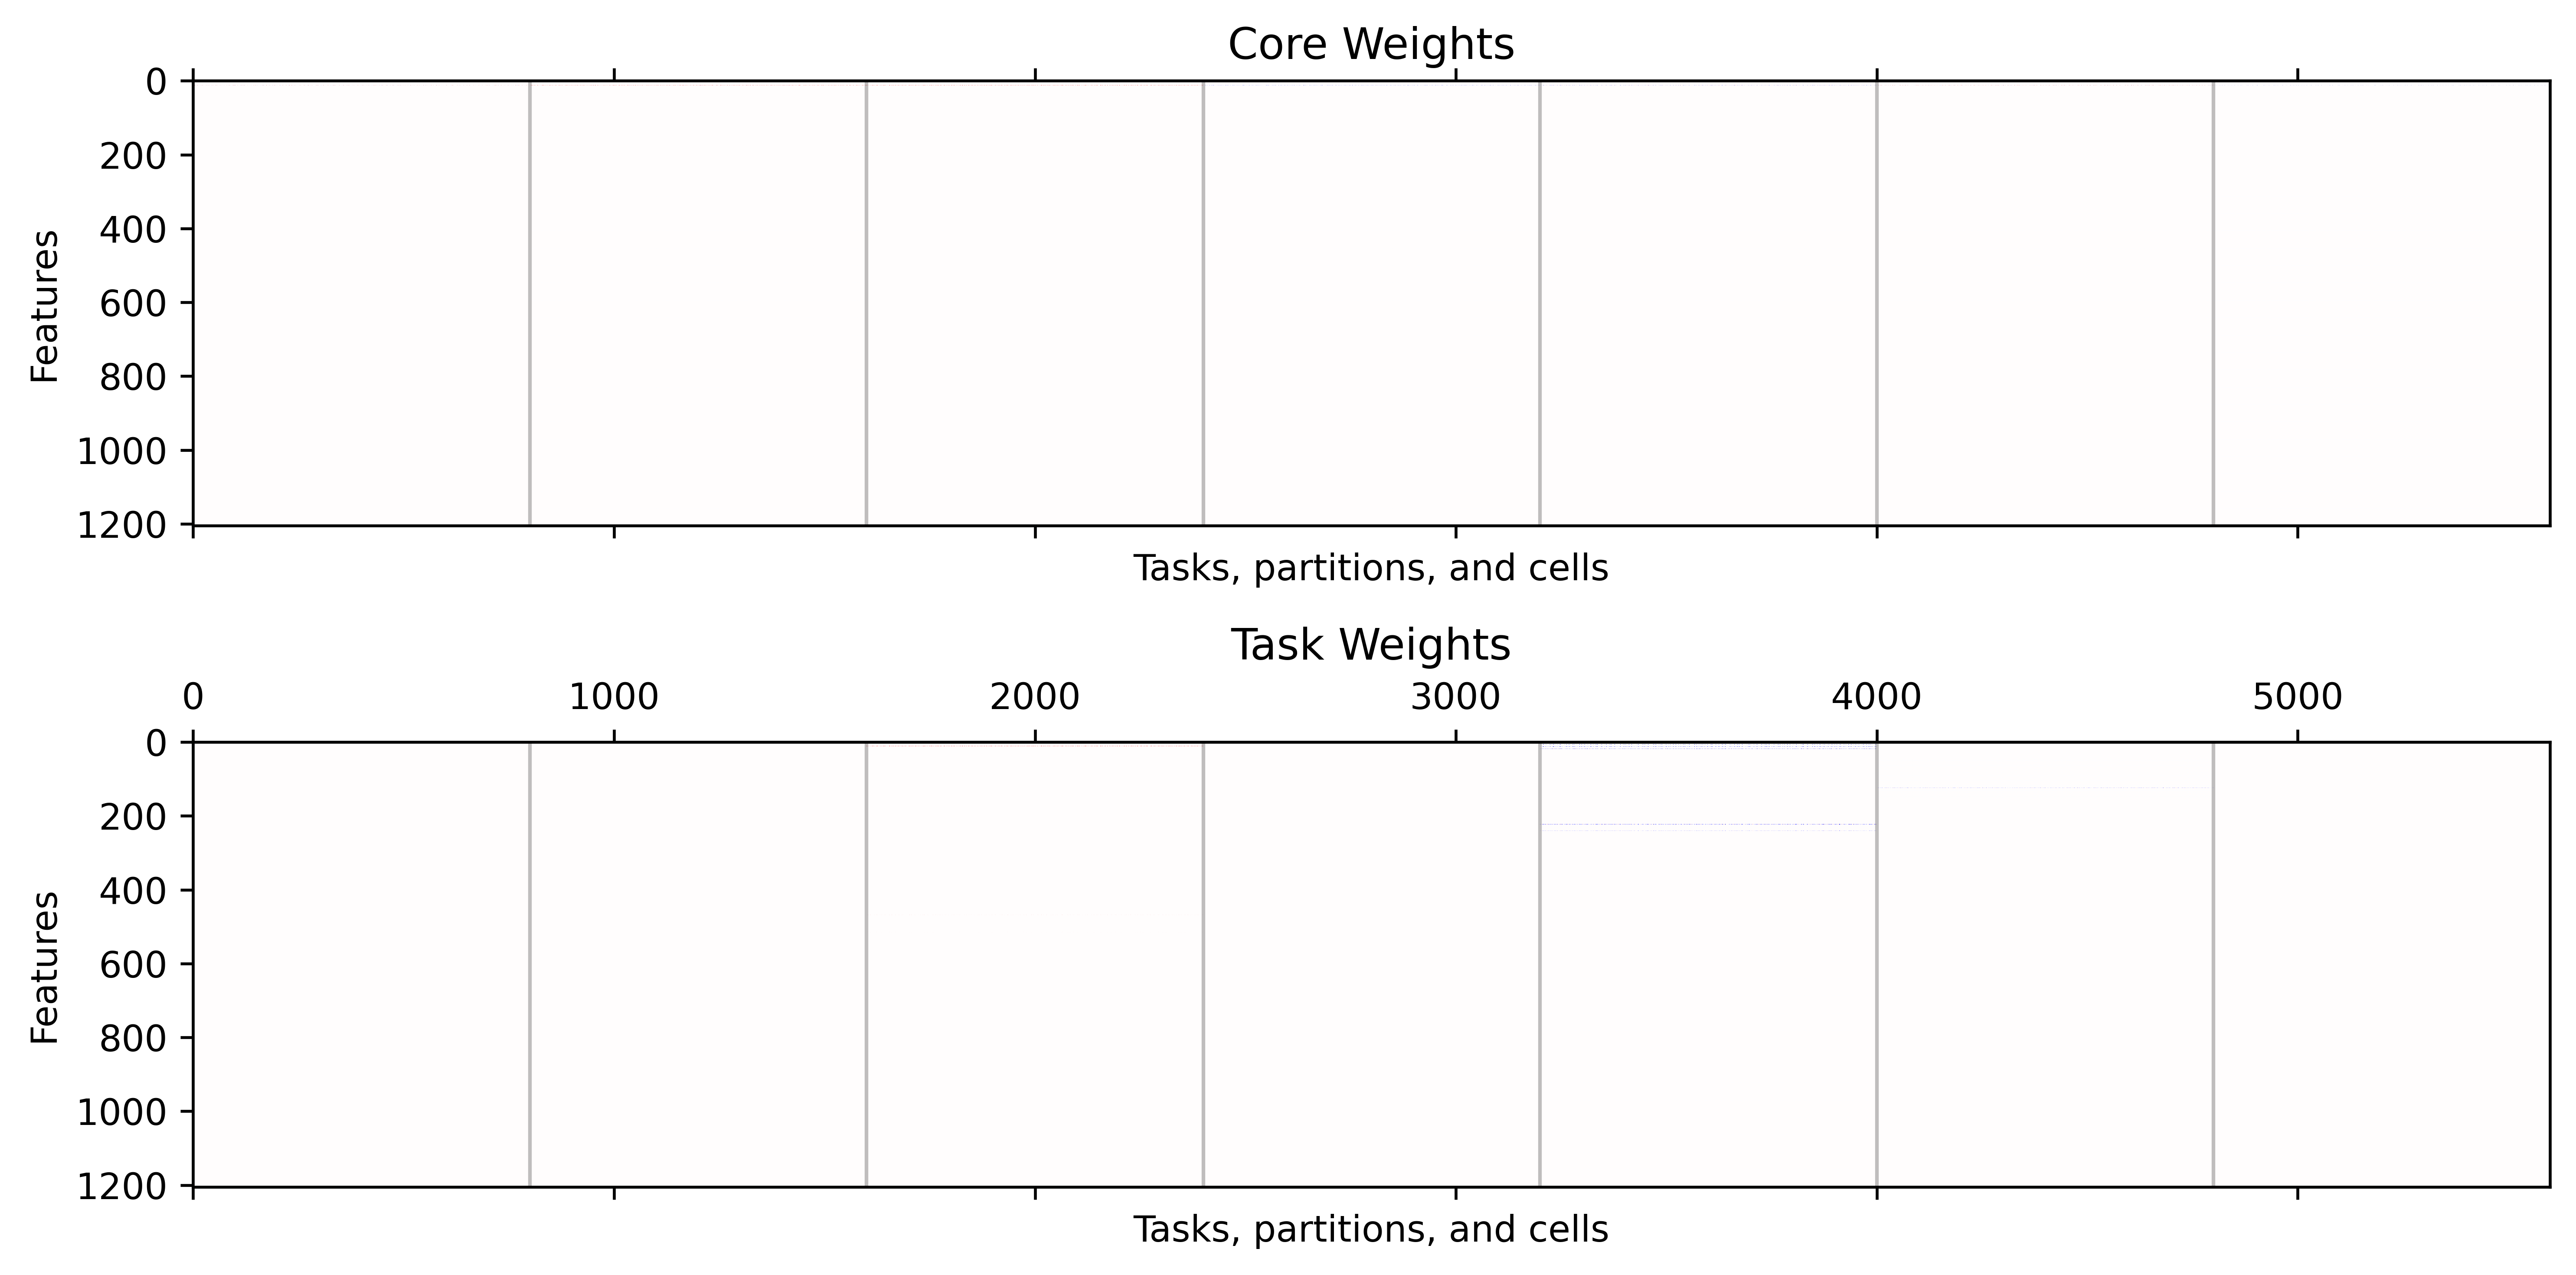

Number of nonzero core weights: 22
Number of nonzero task weights: [0, 0, 3, 0, 8, 1, 0]: 12


In [30]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model, dpi=600)

In [31]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.03,  # shared penalty
    beta=0.02,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

DirtyModel(alpha=0.03, beta=0.02)

Core features: 10
Task features: [0, 0, 87, 5, 0, 0, 1]: 93


,train,val,test
task 0,0.873,0.908,1.003
task 1,0.748,0.845,0.857
task 2,0.405,0.433,0.420
task 3,0.658,0.638,0.683
task 4,0.981,0.857,0.984
task 5,0.991,1.041,0.831
task 6,0.952,0.980,1.018


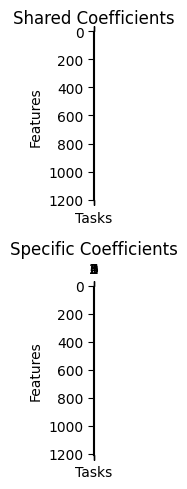

In [32]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))

In [33]:
bouts_model = SMTGBR(
    n_mt_estimators=50,
    n_st_estimators=50,
    max_depth=3,
    random_state=0,
    n_tasks=7,
    feature_penalty=0.0,
)

n_feats = x_train[0].shape[1]

# Some manipulation to get weighting that technically isn't supported by the library
bouts_model.univ_feat_penalty_mask = np.ones(n_feats) * 400
bouts_model.task_feat_penalty_mask = np.ones((bouts_model.n_tasks, n_feats)) * 100

bouts_model.fit(x_train, y_train)

SeqMTGradientBoostingRegressor(n_tasks=7, random_state=0)

In [34]:
feats_df = compare_feats(jp_model, dl_model)
feats_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6
JOPLEn,22,22,25,22,30,23,22
Dirty LASSO,10,10,97,15,10,10,11


In [35]:
bouts_res = score_jp(
    bouts_model,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
)

display(bouts_res.round(3))

plot_bouts_weights(bouts_model)

,train,val,test
task 0,0.469,0.669,0.729
task 1,0.219,0.582,0.628
task 2,0.402,0.470,0.443
task 3,0.436,0.577,0.609
task 4,0.097,0.769,0.298
task 5,0.156,0.931,0.665
task 6,0.704,0.819,0.808


(3, array([2, 2, 2, 2, 1, 1, 2]), 12)

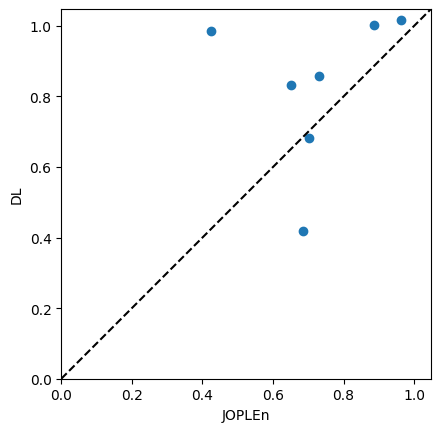

In [36]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

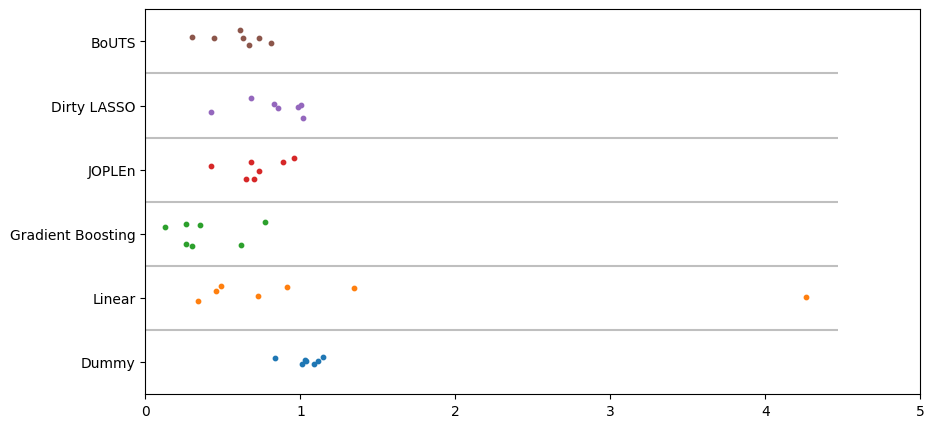

In [37]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res, bouts_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)


plt.xlim(0, 5)

plt.show()

In [38]:
# save results for plotting
save_results(
    "nanoparticle",
    jp_res,
    dl_res,
    bouts_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
    bouts_model,
)